In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [22]:
# parseFasta(data) credit to Luke
def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])
    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

# this method credit to Zhiwen
def get_kmer_table(paths,k_min,k_max):
    genes,gene_len = read_fasta(paths)
    count_vect = CountVectorizer(analyzer='char', ngram_range=(k_min, k_max))
    X = count_vect.fit_transform(genes)
    chars = count_vect.get_feature_names()
    kmers = X.toarray()
    kmer_freq = []
    for i in range(len(genes)):
        kmer_freq.append(kmers[i] / gene_len[i])
    input = pd.DataFrame(kmer_freq, columns=chars)
    return input

# this method credit to Zhiwen
def get_gene_sequences(filename):
    genes = []
    for record in SeqIO.parse(filename, "fasta"):
        genes.append(str(record.seq))
    return genes

# this method credit to Zhiwen
# genes: a list of gene sequences, which can directly be generated from get_gene_sequences().
def get_gene_len(genes):
    gene_len = []

    for i in range(len(genes)):
        gene_len.append(len(genes[i]))
    return gene_len

# this method credit to Zhiwen
def read_fasta(paths):
    all_genes = []
    all_gene_len = []
    
    for path in paths:
        virus = parseFasta(path)
        virus = virus.drop_duplicates(keep="last")
        genes = list(virus['Sequence'])
        genes_seq = get_gene_sequences(path)
        gene_len = get_gene_len(genes_seq)
        all_genes = all_genes + genes_seq
        all_gene_len = all_gene_len + gene_len
    return all_genes,all_gene_len

def spectral_clustering(paths, k_min, k_max, num_cluster, assignLabels):
    kmer_table = get_kmer_table(paths, k_min, k_max)
    spectral_clustering = SpectralClustering(n_clusters= num_cluster, assign_labels = assignLabels, random_state = 0)
    labels = spectral_clustering.fit_predict(kmer_table)
    return labels

def PCA_show_spectural_clustering(paths, k_min, k_max, num_cluster, assignLabels):
    kmer_table = get_kmer_table(paths, k_min, k_max);
    prediction = SpectralClustering(n_clusters = num_cluster, assign_labels=assignLabels, random_state=0).fit_predict(kmer_table)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(kmer_table)
    d = {'dimension1':pca_result[:,0], 'dimension2':pca_result[:,1], 'label':prediction}
    df = pd.DataFrame(d)
    for i in range(num_cluster):
        label = df.loc[df['label'] == i]
        color = 'C'+str(i)
        plt.scatter(label['dimension1'].tolist(),label['dimension2'].tolist(), c = color )
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('Unsupervised Spectral clustring with ' + assignLabels + ' assign label method')
    
def spectral_clustering_with_scaler(paths, k_min, k_max, num_cluster, assignLabels):
    kmer_table = get_kmer_table(paths, k_min, k_max)
    scaler = preprocessing.MinMaxScaler()
    kmer_table = scaler.fit_transform(kmer_table)
    spectral_clustering = SpectralClustering(n_clusters= num_cluster, assign_labels = assignLabels, random_state = 0)
    labels = spectral_clustering.fit_predict(kmer_table)
    return labels

def PCA_show_spectural_clustering_with_scaler(paths, k_min, k_max, num_cluster, assignLabels):
    kmer_table = get_kmer_table(paths, k_min, k_max);
    scaler = preprocessing.MinMaxScaler()
    kmer_table = scaler.fit_transform(kmer_table)
    prediction = SpectralClustering(n_clusters = num_cluster, assign_labels=assignLabels, random_state=0).fit_predict(kmer_table)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(kmer_table)
    d = {'dimension1':pca_result[:,0], 'dimension2':pca_result[:,1], 'label':prediction}
    df = pd.DataFrame(d)
    for i in range(num_cluster):
        label = df.loc[df['label'] == i]
        color = 'C'+str(i)
        plt.scatter(label['dimension1'].tolist(),label['dimension2'].tolist(), c = color )
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('Spectral clustring')
    plt.show()
    
def intuitive_semi_supervised(file_path,label_path, k_min, k_max, num_cluster, assignLabels):
    
   
    labels = pd.read_csv(label_path)
    label_list = labels["Labels"].to_list()
    total_len = len(label_list)
    unknown_label = -1
    
    total_labeled = 0
    optimal_accuracy = 0
    optimal_k_min = 0
    optimal_k_max = 0
    
    for i in label_list:
        if label_list[i] != unknown_label:
            total_labeled = total_labeled + 1

    res = [0]*total_len
    
    for i in range(k_min, k_max + 1):
        for j in range(i, k_max + 1):   
            temp_k_min = i
            temp_k_max = j

            kmer_table = get_kmer_table(file_path, temp_k_min, temp_k_max)
            
            spectral_clustering = SpectralClustering(n_clusters= num_cluster, assign_labels = assignLabels, random_state=699)
            
            labels = spectral_clustering.fit_predict(kmer_table)
            
            correct_count = 0
            temp_accuracy = 0
          
            for k in range(len(label_list)):
                
                if(label_list[k] !=unknown_label):
                    
                    if(label_list[k] == labels[k]):
                        correct_count += 1
            temp_accuracy = correct_count/total_labeled
            
            if(temp_accuracy > optimal_accuracy):
                optimal_accuracy = temp_accuracy
                optimal_k_min = i
                optimal_k_max = j
                res = labels
    print("The optimal accuracy based on labeled sequences is: " + str(optimal_accuracy))
    print("The optimal k_min is: " + str(optimal_k_min))
    print("The optimal k_max is: " + str(optimal_k_max))
    return res

def PCA_show_semi_spectural_clustering(file_path,label_path, k_min, k_max, num_cluster, assignLabels):
    
    prediction = intuitive_semi_supervised(file_path,label_path, k_min, k_max, num_cluster, assignLabels)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(kmer_table)
    d = {'dimension1':pca_result[:,0], 'dimension2':pca_result[:,1], 'label':prediction}
    df = pd.DataFrame(d)
    for i in range(num_cluster):
        label = df.loc[df['label'] == i]
        color = 'C'+str(i)
        plt.scatter(label['dimension1'].tolist(),label['dimension2'].tolist(), c = color )
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('Semi-supervised Spectral clustring with ' + assignLabels + ' assign label method')
    

In [25]:
new_paths = ["combined.fa"]
k_min = 2
k_max = 6
num_class = 2
kmer_table = get_kmer_table(new_paths, k_min, k_max)
result = intuitive_semi_supervised(new_paths,"labels_fifty_percent.csv",k_min,k_max,num_class,'kmeans')

The optimal accuracy based on labeled sequences is: 0.7415730337078652
The optimal k_min is: 2
The optimal k_max is: 2


In [27]:
new_paths = ["combined.fa"]
k_min = 2
k_max = 6
num_class = 2
kmer_table = get_kmer_table(new_paths, k_min, k_max)
result = intuitive_semi_supervised(new_paths,"labels_ten_percent.csv",k_min,k_max,num_class,'kmeans')
result

The optimal accuracy based on labeled sequences is: 0.6470588235294118
The optimal k_min is: 2
The optimal k_max is: 2


array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

### Below is the plots and results for various datasets

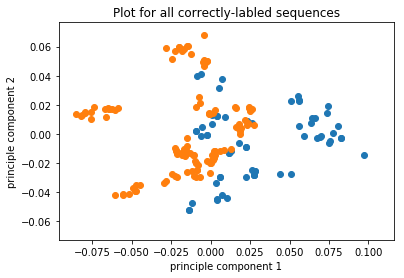

In [66]:
bat_len = len(get_gene_sequences("bat_flu.fa"))

cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*cat_len, axis=None)
paths = ["combined.fa"]

optimal_kmer_table = get_kmer_table(paths, 2, 6);
pca = PCA(n_components=2)
pca_result = pca.fit_transform(optimal_kmer_table)
labels1 = np.append(zeros, [1]*cat_len, axis=None)

d = {'dimension1':pca_result[:,0], 'dimension2':pca_result[:,1], 'label':labels1}
df = pd.DataFrame(d)
label_0 = df.loc[df['label'] == 0]
label_1 = df.loc[df['label'] == 1]
plt.scatter(label_0['dimension1'].tolist(),label_0['dimension2'].tolist(), c = 'C0' )
plt.scatter(label_1['dimension1'].tolist(),label_1['dimension2'].tolist(), c = 'C1' )
plt.xlabel('principle component 1')
plt.ylabel('principle component 2')
plt.title('Plot for all correctly-labled sequences')
plt.show()

In [71]:
df.to_csv(r'export_PCA.csv')

The optimal accuracy based on labeled sequences is: 0.7415730337078652
The optimal k_min is: 3
The optimal k_max is: 5
The optimal accuracy based on labeled sequences is: 0.7415730337078652
The optimal k_min is: 3
The optimal k_max is: 5


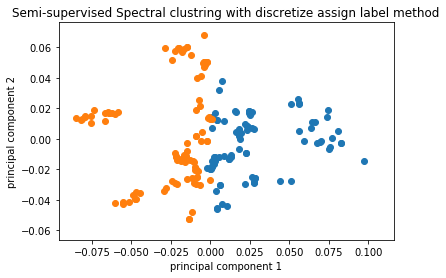

In [74]:
k_min = 2
k_max = 6
result = intuitive_semi_supervised(new_paths,"labels_fifty_percent.csv",k_min,k_max,num_class,'discretize')
result_df = pd.DataFrame(result)
result_df.to_csv(r'result_semi_50_dis.csv')
PCA_show_semi_spectural_clustering(new_paths,"labels_fifty_percent.csv",k_min,k_max,num_class,'discretize')

The optimal accuracy based on labeled sequences is: 0.7647058823529411
The optimal k_min is: 3
The optimal k_max is: 3
The optimal accuracy based on labeled sequences is: 0.7647058823529411
The optimal k_min is: 3
The optimal k_max is: 3


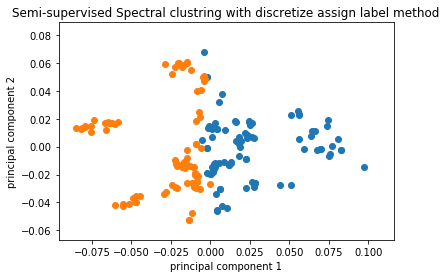

In [75]:
result = intuitive_semi_supervised(new_paths,"labels_ten_percent.csv",k_min,k_max,num_class,'discretize')
result_df = pd.DataFrame(result)
result_df.to_csv(r'result_semi_10_dis.csv')
PCA_show_semi_spectural_clustering(new_paths,"labels_ten_percent.csv",k_min,k_max,num_class,'discretize')

The optimal accuracy based on labeled sequences is: 0.7415730337078652
The optimal k_min is: 2
The optimal k_max is: 2
The optimal accuracy based on labeled sequences is: 0.7415730337078652
The optimal k_min is: 2
The optimal k_max is: 2


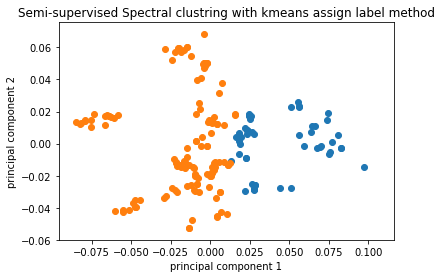

In [77]:
result = intuitive_semi_supervised(new_paths,"labels_fifty_percent.csv",k_min,k_max,num_class,'kmeans')
result_df = pd.DataFrame(result)
result_df.to_csv(r'result_semi_50_kmeans.csv')
PCA_show_semi_spectural_clustering(new_paths,"labels_fifty_percent.csv",k_min,k_max,num_class,'kmeans')

The optimal accuracy based on labeled sequences is: 0.6470588235294118
The optimal k_min is: 2
The optimal k_max is: 2
The optimal accuracy based on labeled sequences is: 0.6470588235294118
The optimal k_min is: 2
The optimal k_max is: 2


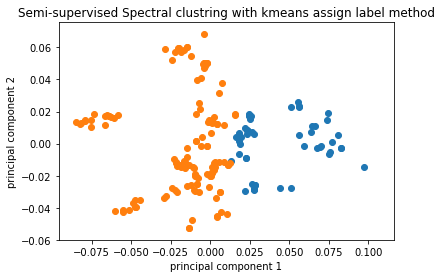

In [78]:
result = intuitive_semi_supervised(new_paths,"labels_ten_percent.csv",k_min,k_max,num_class,'kmeans')
result_df = pd.DataFrame(result)
result_df.to_csv(r'result_semi_10_kmeans.csv')
PCA_show_semi_spectural_clustering(new_paths,"labels_ten_percent.csv",k_min,k_max,num_class,'kmeans')

0.7584269662921348

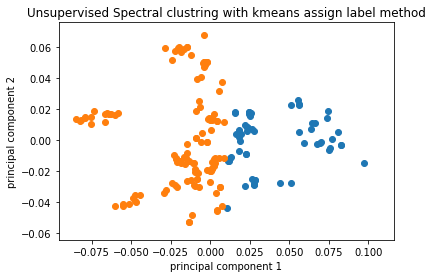

In [80]:
bat_len = len(get_gene_sequences("bat_flu.fa"))

cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*cat_len, axis=None)

paths = ["combined.fa"]
k_min = 2
k_max = 6
num_cluster = 2
assignLabels = "kmeans"
labels = spectral_clustering(paths, k_min, k_max, num_cluster, assignLabels)
PCA_show_spectural_clustering(paths, k_min, k_max, num_cluster, assignLabels)
accuracy = 1 - sum(abs(labels1 - labels))/(bat_len+cat_len)
accuracy

result_df = pd.DataFrame(labels)
result_df.to_csv(r'unsupervised_result.csv')
accuracy

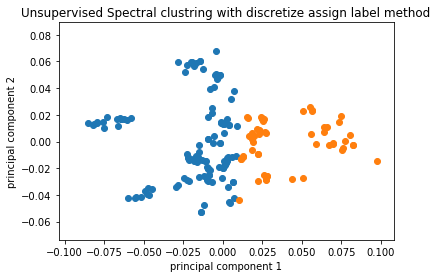

In [52]:
assignLabels = "discretize"
labels = spectral_clustering(paths, k_min, k_max, num_cluster, assignLabels)
PCA_show_spectural_clustering(paths, k_min, k_max, num_cluster, assignLabels)


### Below is the "scratch paper"

In [46]:
bat_len = len(get_gene_sequences("bat_flu.fa"))

cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*cat_len, axis=None)

In [192]:
paths = ["bat_flu.fa","cat_flu.fa"]
accuracy_kmeans = 0
optimal_k_min = 0
optimal_k_max = 0
optimal_prediction = [0]*(bat_len+cat_len)
for i in range(2, 6):
    for j in range(i + 1, 8):   
        k_min = i
        k_max = j
        num_class = 2
        predictions_kmeans = spectral_clustering(paths,k_min,k_max,num_class,'kmeans')
        correct_count = 0
 
        temp_accuracy = 1 - sum(abs(labels1 - predictions_kmeans))/(bat_len+cat_len)
        
        if(temp_accuracy > accuracy_kmeans):
            accuracy_kmeans = temp_accuracy
            optimal_k_min = i
            optimal_k_max = j
            optimal_prediction = predictions_kmeans
accuracy_kmeans

0.7640449438202247

In [132]:
labels1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [133]:
optimal_prediction

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [13]:
optimal_kmer_table = get_kmer_table(paths, optimal_k_min, optimal_k_max);
optimal_clustering = SpectralClustering(n_clusters = 3, assign_labels="kmeans", random_state=0).fit(optimal_kmer_table)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(optimal_kmer_table)
print(pca.explained_variance_ratio_)

[0.3503331  0.18031036]


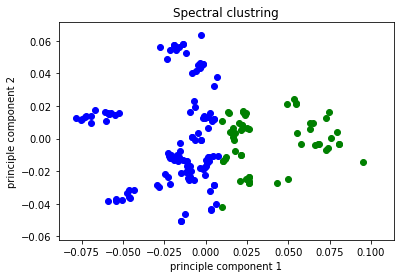

In [15]:
d = {'dimension1':pca_result[:,0], 'dimension2':pca_result[:,1], 'label':optimal_prediction}
df = pd.DataFrame(d)
label_0 = df.loc[df['label'] == 0]
label_1 = df.loc[df['label'] == 1]
plt.scatter(label_0['dimension1'].tolist(),label_0['dimension2'].tolist(), c = 'green' )
plt.scatter(label_1['dimension1'].tolist(),label_1['dimension2'].tolist(), c = 'blue' )
plt.xlabel('principle component 1')
plt.ylabel('principle component 2')
plt.title('Spectral clustring')
plt.show()


In [75]:
paths = ["bat_flu.fa","cat_flu.fa"]
accuracy_discrete = 0
optimal_k_min = 0
optimal_k_max = 0
optimal_prediction_discrete = [0]*(bat_len+cat_len)
for i in range(2, 6):
    for j in range(i + 1, 8):

        k_min = i
        k_max = j
        num_class = 2
        predictions_d = spectral_clustering(paths,k_min,k_max,num_class,'discretize')
        temp_accuracy = 1 - sum(abs(labels1 - predictions_d))/(bat_len+cat_len)
        if(temp_accuracy > accuracy_discrete):
            accuracy_discrete = temp_accuracy
            optimal_k_min = i
            optimal_k_max = j
            optimal_prediction_discrete = predictions_d
accuracy_discrete

0.5561797752808989

In [76]:
optimal_prediction_discrete

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0], dtype=int64)